# exploratory analysis of the gbyk experiment

click [here](https://www.notion.so/oliveiracaio/in-progress-exploratory-analysis-of-the-gbyk-experiment-17ca2d01e2ff80b28fa1e28899d36bd3?pvs=25) to access the corresponding notion page.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import warnings

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import motorlab as ml

In [3]:
os.chdir(Path().resolve().parent)

warnings.filterwarnings(
    "ignore",
    message="n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.",
    module="umap.umap_",
)

In [4]:
sns.set_context("poster", font_scale=2.0)
sns.set_style("white")
sns.set_theme(style="ticks")

EXPERIMENT = "gbyk"
DATA_DIR = Path("data")
PLOTS_DIR = Path("artifacts/plots/gbyk_exploratory/")
PALETTE = sns.color_palette(
    [
        sns.xkcd_rgb["electric pink"],
        sns.xkcd_rgb["neon blue"],
        sns.xkcd_rgb["bright red"],
        sns.xkcd_rgb["blue"],
        sns.xkcd_rgb["black"],
        sns.xkcd_rgb["mango"],
    ]
)
SESSIONS = ml.sessions.GBYK
SESSIONS = ml.sessions.OLD_GBYK

## intervals

In [5]:
intervals_info = dict()

for session in SESSIONS:
    intervals_dir = DATA_DIR / EXPERIMENT / session / "intervals"
    intervals_info[session] = ml.data.load_intervals_as_pandas(intervals_dir)

intervals_info = pd.concat(
    [df.assign(session=session) for session, df in intervals_info.items()],
    ignore_index=True,
)

In [6]:
summary = (
    intervals_info.groupby(["session", "type", "side"])
    .agg(
        count=("side", "size"),
        mistake=(
            "reward",
            lambda x: (
                intervals_info.loc[x.index, "side"]
                != intervals_info.loc[x.index, "reward"]
            ).sum(),
        ),
    )
    .unstack(["type", "side"], fill_value=0)
    .reset_index()
)

summary.columns = ["session"] + [
    f"{t} {c} {stat}" for stat, t, c in summary.columns[1:]
]
summary

,session,homing L count,homing R count,precue L count,precue R count,gbyk L count,gbyk R count,homing L mistake,homing R mistake,precue L mistake,precue R mistake,gbyk L mistake,gbyk R mistake
0,bex_20230623_denoised,28,20,37,36,0,0,0,0,2,2,0,0
1,ken_20230614_denoised,39,63,36,35,34,32,0,0,2,1,0,0
2,ken_20230618_denoised,30,62,69,75,0,0,0,0,3,6,0,0


### histograms of trial duration

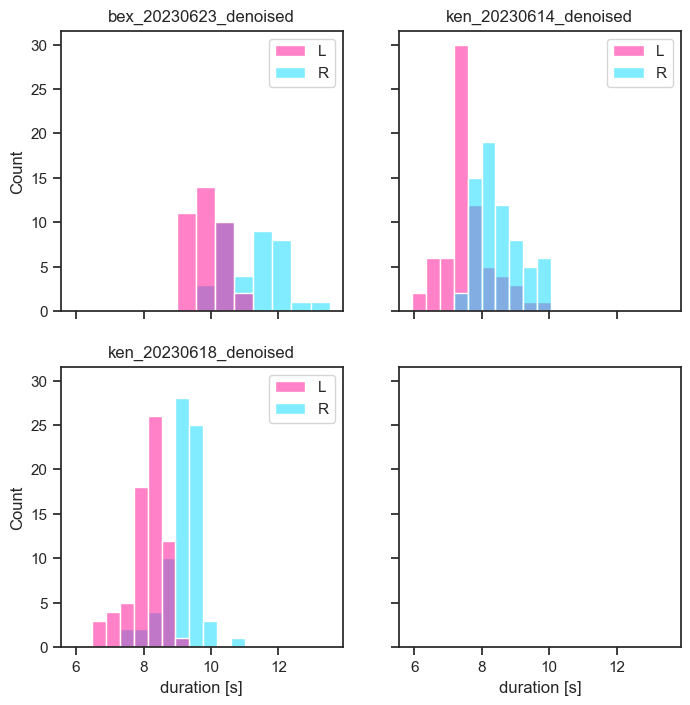

In [7]:
ncols = 2
nrows = len(SESSIONS) // ncols + (len(SESSIONS) % ncols > 0)
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(4 * ncols, 4 * nrows),
    sharex=True,
    sharey=True,
)

# converts to seconds
intervals_info["duration"] = intervals_info["num_frames"] / 1000
hue_order = ["L", "R"]
side_palette = {"L": PALETTE[0], "R": PALETTE[1]}

for i, session in enumerate(SESSIONS):
    query = (intervals_info["session"] == session) & (
        intervals_info["type"] != "homing"
    )
    axs[i // ncols, i % ncols].set_title(session, pad=7)

    g = sns.histplot(
        data=intervals_info[query],
        x="duration",
        hue="side",
        ax=axs[i // ncols, i % ncols],
        palette=side_palette,
        legend=True,
    )

    legend = axs[i // ncols, i % ncols].get_legend()
    handles = legend.get_patches()
    labels = [t.get_text() for t in legend.get_texts()]
    sorted_pairs = sorted(zip(handles, labels), key=lambda x: x[1])
    sorted_handles, sorted_labels = zip(*sorted_pairs)
    axs[i // ncols, i % ncols].legend(sorted_handles, sorted_labels)

for ax in axs.flat:
    ax.set_xlabel("duration [s]")

# plt.savefig(
#     PLOTS_DIR / "histogram_trials_side.svg",
#     bbox_inches="tight",
# )
plt.show()

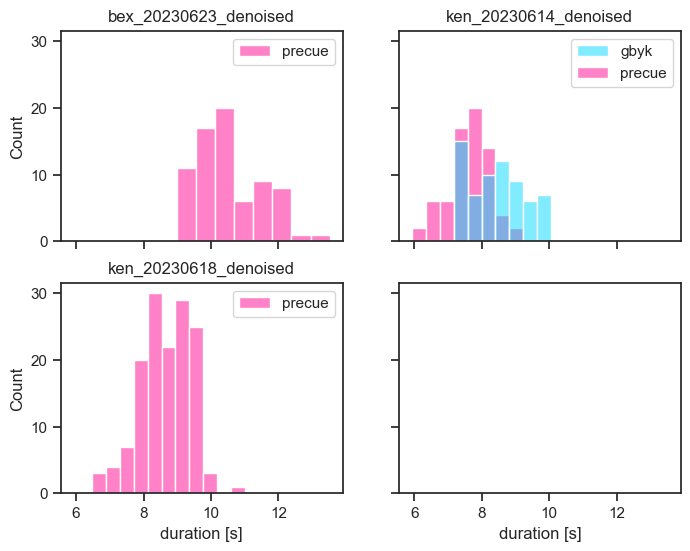

In [8]:
ncols = 2
nrows = len(SESSIONS) // ncols + (len(SESSIONS) % ncols > 0)
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(4 * ncols, 3 * nrows),
    sharex=True,
    sharey=True,
)

hue_order = ["precue", "gbyk"]
type_palette = {"precue": PALETTE[0], "gbyk": PALETTE[1]}

for i, session in enumerate(SESSIONS):
    query = (intervals_info["session"] == session) & (
        intervals_info["type"] != "homing"
    )
    axs[i // ncols, i % ncols].set_title(session, pad=7)

    g = sns.histplot(
        intervals_info[query],
        x="duration",
        hue="type",
        ax=axs[i // ncols, i % ncols],
        palette=type_palette,
        legend=True,
    )

    legend = axs[i // ncols, i % ncols].get_legend()
    handles = legend.get_patches()
    labels = [t.get_text() for t in legend.get_texts()]
    sorted_pairs = sorted(zip(handles, labels), key=lambda x: x[1])
    sorted_handles, sorted_labels = zip(*sorted_pairs)
    axs[i // ncols, i % ncols].legend(sorted_handles, sorted_labels)

for ax in axs.flat:
    ax.set_xlabel("duration [s]")

# plt.savefig(
#     PLOTS_DIR / "histogram_trials_type.svg",
#     bbox_inches="tight",
# )
plt.show()

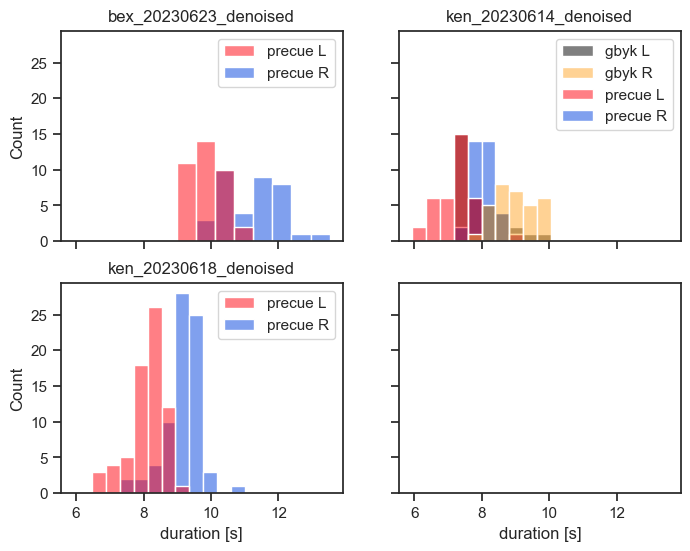

In [9]:
ncols = 2
nrows = len(SESSIONS) // ncols + (len(SESSIONS) % ncols > 0)
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(4 * ncols, 3 * nrows),
    sharex=True,
    sharey=True,
)

intervals_info["type_side"] = (
    intervals_info["type"] + " " + intervals_info["side"]
)
hue_order = ["precue L", "precue R", "gbyk L", "gbyk R"]
combined_palette = {
    "precue L": PALETTE[2],
    "precue R": PALETTE[3],
    "gbyk L": PALETTE[4],
    "gbyk R": PALETTE[5],
}

for i, session in enumerate(SESSIONS):
    query = (intervals_info["session"] == session) & (
        intervals_info["type"] != "homing"
    )
    axs[i // ncols, i % ncols].set_title(session, pad=7)

    g = sns.histplot(
        intervals_info[query],
        x="duration",
        hue="type_side",
        ax=axs[i // ncols, i % ncols],
        palette=combined_palette,
        legend=True,
    )

    legend = axs[i // ncols, i % ncols].get_legend()
    handles = legend.get_patches()
    labels = [t.get_text() for t in legend.get_texts()]
    sorted_pairs = sorted(zip(handles, labels), key=lambda x: x[1])
    sorted_handles, sorted_labels = zip(*sorted_pairs)
    axs[i // ncols, i % ncols].legend(sorted_handles, sorted_labels)

for ax in axs.flat:
    ax.set_xlabel("duration [s]")

# plt.savefig(
#     PLOTS_DIR / "histogram_trials_condition.svg",
#     bbox_inches="tight",
# )
plt.show()

### traces of the center of mass during trials

/var/folders/b2/8s0j82vd4439gm59q0ydywkm0000gn/T/ipykernel_29363/3926823747.py:25: RuntimeWarning: Mean of empty slice
  com = np.nanmean(com, axis=1)


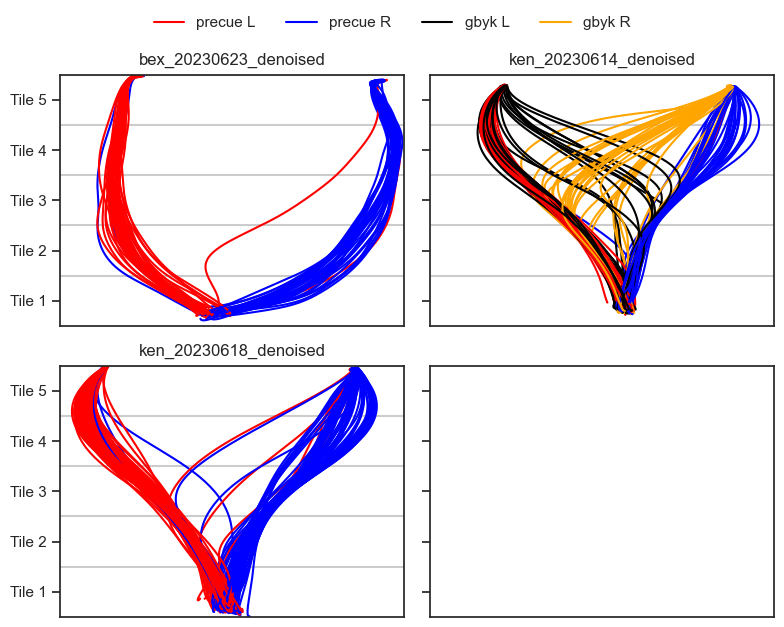

In [29]:
ncols = 2
nrows = len(SESSIONS) // ncols + (len(SESSIONS) % ncols > 0)
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(4 * ncols, 3 * nrows),
    sharex=True,
    sharey=True,
)

tile_size = ml.room.y_size / ml.room.y_divisions
ylines = [(i + 1) * tile_size for i in range(ml.room.y_divisions)]
for i, session in enumerate(SESSIONS):
    axs[i // ncols, i % ncols].set_title(session, pad=7)
    for y in ylines:
        axs[i // ncols, i % ncols].axhline(
            y=y, color="black", linestyle="-", alpha=0.2
        )
    com = np.load(
        DATA_DIR / EXPERIMENT / session / "poses" / "meta" / "com.npy",
        allow_pickle=True,
    )
    duration = len(com) - (len(com) % 5)
    com = com[:duration].reshape(-1, 5, 3)
    com = np.nanmean(com, axis=1)
    query = (intervals_info["session"] == session) & (
        intervals_info["type"] != "homing"
    )
    types = intervals_info[query]["type"].values.astype(str)
    rewards = intervals_info[query]["reward"].values.astype(str)
    starts = intervals_info[query]["first_frame_idx"].values.astype(int) // 50
    ends = starts + intervals_info[query]["num_frames"].values.astype(int) // 50

    for j in range(len(types)):
        if types[j] == "precue":
            color = "red" if rewards[j] == "L" else "blue"
        else:
            color = "black" if rewards[j] == "L" else "orange"
        axs[i // ncols, i % ncols].plot(
            com[starts[j] : ends[j], 0],
            com[starts[j] : ends[j], 1],
            color=color,
            label=types[j] + " " + rewards[j],
        )

handles = [
    plt.Line2D([], [], color="red", label="precue L"),
    plt.Line2D([], [], color="blue", label="precue R"),
    plt.Line2D([], [], color="black", label="gbyk L"),
    plt.Line2D([], [], color="orange", label="gbyk R"),
]
fig.legend(
    handles=handles,
    frameon=False,
    loc="center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=4,
)
plt.xticks([])
yticks_positions = [
    i * tile_size + tile_size / 2 for i in range(ml.room.y_divisions)
]
yticks_labels = ["Tile 1", "Tile 2", "Tile 3", "Tile 4", "Tile 5"]
axs[0, 0].set_yticks(yticks_positions)
axs[0, 0].set_yticklabels(yticks_labels)
axs[0, 0].set_ylim(0, ml.room.y_size)
axs[0, 0].set_xlim(0, ml.room.x_size)

plt.tight_layout()
# plt.savefig(PLOTS_DIR / "traces_com_trials_condition.svg", bbox_inches="tight")
plt.show()

### histograms of homing duration

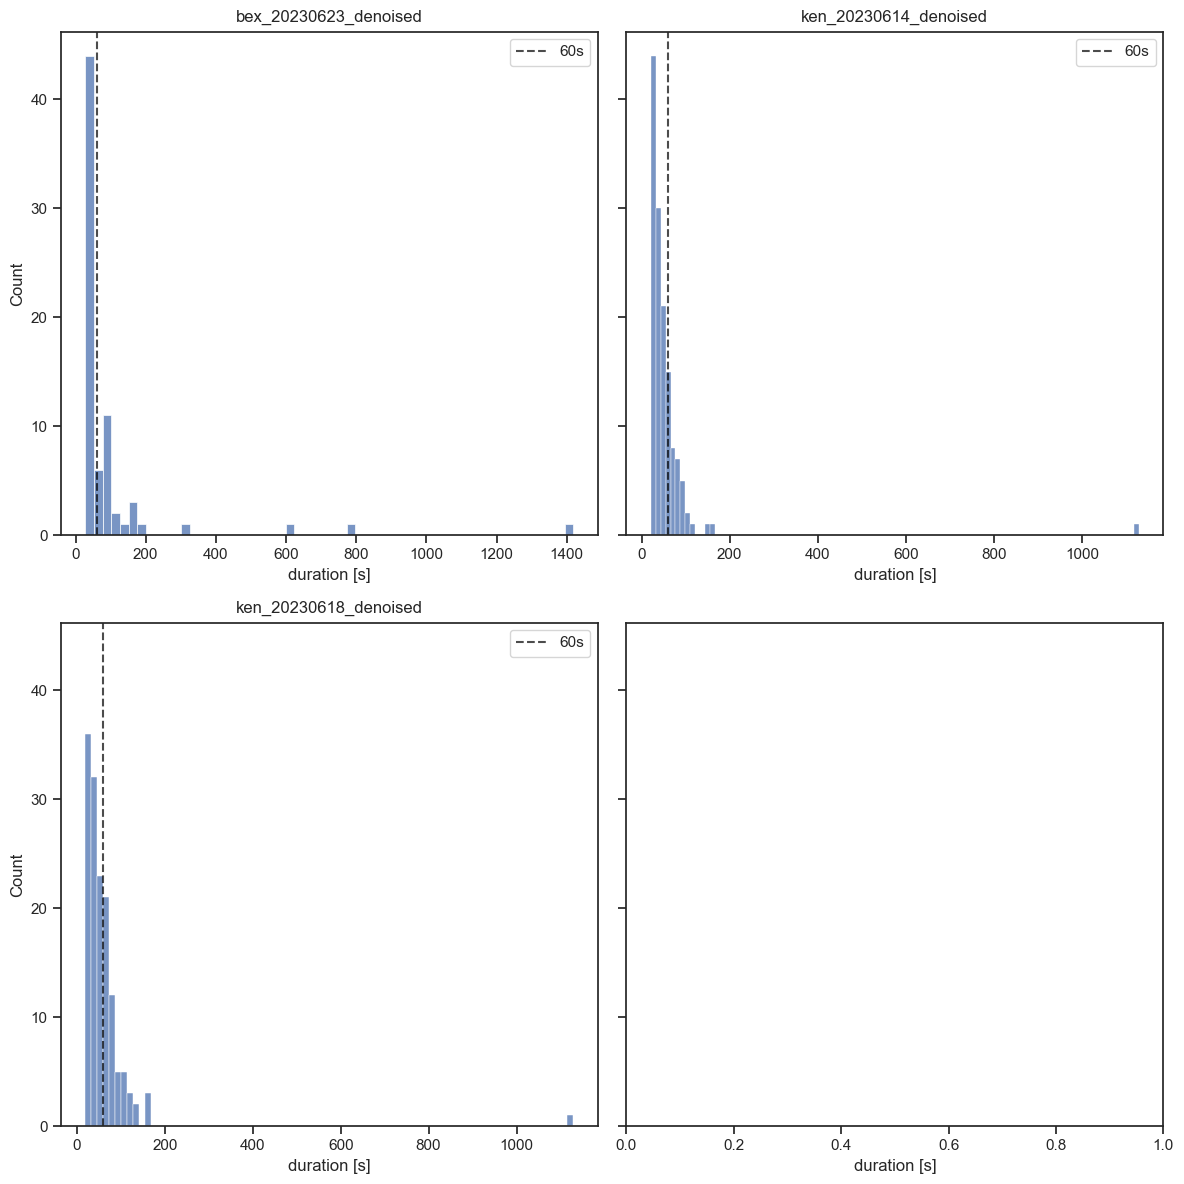

In [31]:
ncols = 2
nrows = len(SESSIONS) // ncols + (len(SESSIONS) % ncols > 0)
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(6 * ncols, 6 * nrows),
    sharey=True,
)

inter_trials_dict = {
    "session": [],
    "duration": [],
}
no_homing_df = intervals_info[intervals_info["type"] != "homing"]

for i in range(len(no_homing_df) - 1):
    row_i = no_homing_df.iloc[i]
    row_i_plus_1 = no_homing_df.iloc[i + 1]

    if row_i["session"] != row_i_plus_1["session"]:
        continue

    end_i = row_i["first_frame_idx"] + row_i["num_frames"]
    start_i_plus_1 = row_i_plus_1["first_frame_idx"]
    inter_trials_dict["session"].append(row_i["session"])
    inter_trials_dict["duration"].append((start_i_plus_1 - end_i) / 1000)

inter_trials_df = pd.DataFrame(inter_trials_dict)

for i, session in enumerate(SESSIONS):
    axs[i // ncols, i % ncols].set_title(session, pad=7)

    g = sns.histplot(
        data=inter_trials_df[inter_trials_df["session"] == session],
        x="duration",
        ax=axs[i // ncols, i % ncols],
    )

    axs[i // ncols, i % ncols].axvline(
        x=60,
        color="black",
        linestyle="--",
        alpha=0.7,
        label="60s",
    )
    axs[i // ncols, i % ncols].legend()

for ax in axs.flat:
    ax.set_xlabel("duration [s]")

plt.tight_layout()
# plt.savefig(
#     PLOTS_DIR / "histogram_inter_trials.svg",
#     bbox_inches="tight",
# )
plt.show()

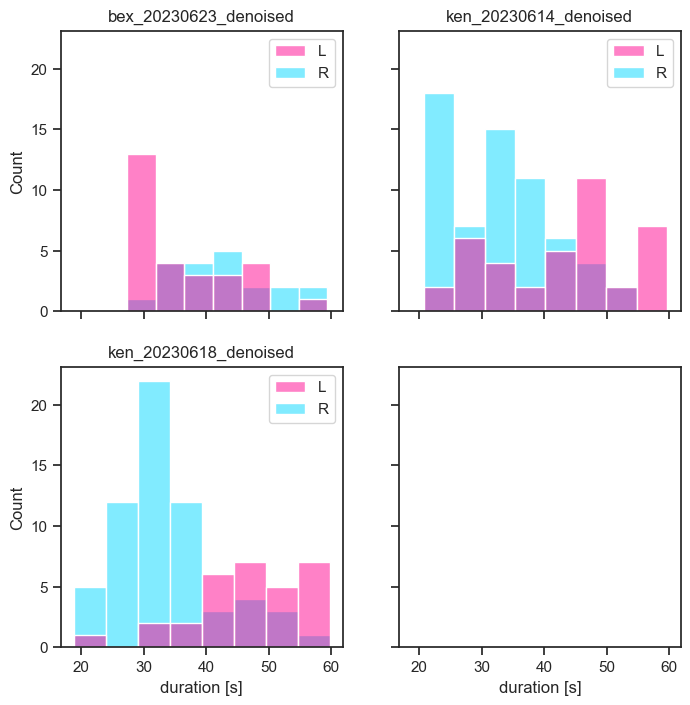

In [ ]:
ncols = 2
nrows = len(SESSIONS) // ncols + (len(SESSIONS) % ncols > 0)
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(4 * ncols, 4 * nrows),
    sharex=True,
    sharey=True,
)

hue_order = ["L", "R"]
side_palette = {"L": PALETTE[0], "R": PALETTE[1]}

for i, session in enumerate(SESSIONS):
    query = (intervals_info["session"] == session) & (
        intervals_info["type"] == "homing"
    )
    axs[i // ncols, i % ncols].set_title(session, pad=7)

    g = sns.histplot(
        data=intervals_info[query],
        x="duration",
        hue="side",
        ax=axs[i // ncols, i % ncols],
        palette=side_palette,
        legend=True,
    )

    legend = axs[i // ncols, i % ncols].get_legend()
    handles = legend.get_patches()
    labels = [t.get_text() for t in legend.get_texts()]
    sorted_pairs = sorted(zip(handles, labels), key=lambda x: x[1])
    sorted_handles, sorted_labels = zip(*sorted_pairs)
    axs[i // ncols, i % ncols].legend(sorted_handles, sorted_labels)

for ax in axs.flat:
    ax.set_xlabel("duration [s]")

plt.tight_layout()
# plt.savefig(
#     PLOTS_DIR / "histogram_homing_side.svg",
#     bbox_inches="tight",
# )
plt.show()

## spikes

i'm using spike count instead of the raw spike train because it loads faster. very simple plot: compute firing rate of each neuron, split between areas, then plot as a boxplot.

In [33]:
firing_rates_dict = {
    "session": [],
    "area": [],
    "firing_rate": [],
}
areas_dict = {
    "session": [],
    "m1_l": [],
    "m1_m": [],
    "pmd_l": [],
    "pmd_m": [],
    "dlpfc": [],
    "total": [],
}

for i, session in enumerate(SESSIONS):
    poses_dir = DATA_DIR / EXPERIMENT / session / "spike_count"
    spike_count = ml.data.load_from_memmap(poses_dir)
    areas = np.load(poses_dir / "meta" / "areas.npy", allow_pickle=True)
    areas = np.char.lower(areas)

    # the 20 is because i binned the spike count into 50ms.
    firing_rates = 20 * spike_count.sum(axis=0) / spike_count.shape[0]

    areas_dict["session"].append(session)
    areas_dict["m1_l"].append(np.sum(areas == "m1_l"))
    areas_dict["m1_m"].append(np.sum(areas == "m1_m"))
    areas_dict["pmd_l"].append(np.sum(areas == "pmd_l"))
    areas_dict["pmd_m"].append(np.sum(areas == "pmd_m"))
    areas_dict["dlpfc"].append(np.sum(areas == "dlpfc"))
    areas_dict["total"].append(spike_count.shape[1])

    m1_l_fr = firing_rates[areas == "m1_l"]
    m1_m_fr = firing_rates[areas == "m1_m"]
    pmd_l_fr = firing_rates[areas == "pmd_l"]
    pmd_m_fr = firing_rates[areas == "pmd_m"]
    dlpfc_fr = firing_rates[areas == "dlpfc"]

    firing_rates_dict["session"].extend([session] * spike_count.shape[1])
    firing_rates_dict["area"].extend(
        ["m1_l"] * len(m1_l_fr)
        + ["m1_m"] * len(m1_m_fr)
        + ["pmd_l"] * len(pmd_l_fr)
        + ["pmd_m"] * len(pmd_m_fr)
        + ["dlpfc"] * len(dlpfc_fr)
    )
    firing_rates_dict["firing_rate"].extend(
        list(m1_l_fr)
        + list(m1_m_fr)
        + list(pmd_l_fr)
        + list(pmd_m_fr)
        + list(dlpfc_fr)
    )

firing_rates_df = pd.DataFrame(firing_rates_dict)
areas_df = pd.DataFrame(areas_dict)

In [34]:
firing_rates_df

,session,area,firing_rate
0,bex_20230623_denoised,m1_l,34.851101
1,bex_20230623_denoised,m1_l,5.958910
2,bex_20230623_denoised,m1_l,12.533599
3,bex_20230623_denoised,m1_l,13.182083
4,bex_20230623_denoised,m1_l,6.779822
...,...,...,...
579,ken_20230618_denoised,dlpfc,39.283195
580,ken_20230618_denoised,dlpfc,24.687559
581,ken_20230618_denoised,dlpfc,12.089339
582,ken_20230618_denoised,dlpfc,43.005993


In [35]:
areas_df

,session,m1_l,m1_m,pmd_l,pmd_m,dlpfc,total
0,bex_20230623_denoised,24,23,32,18,0,97
1,ken_20230614_denoised,30,32,59,62,60,243
2,ken_20230618_denoised,30,28,60,64,62,244


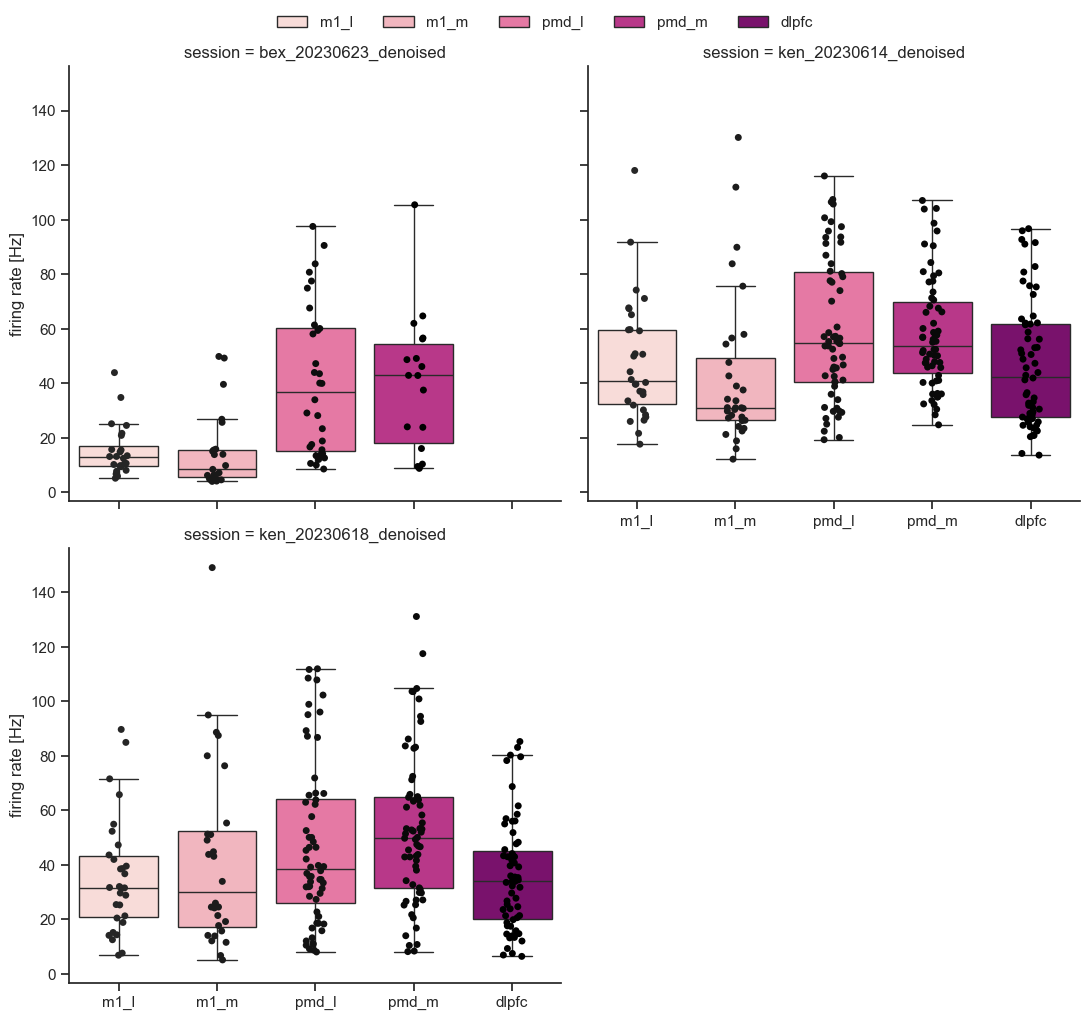

In [36]:
FR_PALETTE = sns.color_palette("RdPu", n_colors=5)

g = sns.catplot(
    data=firing_rates_df,
    col="session",
    hue="area",
    x="area",
    y="firing_rate",
    kind="box",
    palette=FR_PALETTE,
    legend=True,
    col_wrap=2,
    fliersize=0,
)

# Add stripplot to each facet
g.map_dataframe(
    sns.stripplot,
    x="area",
    y="firing_rate",
    hue="area",
    dodge=False,
    jitter=True,
    palette="dark:black",
    legend=False,
)

g.set_axis_labels("", "firing rate [Hz]")
legend = g._legend
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]
legend.remove()
g.fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.5, 1.005),
    loc="center",
    frameon=False,
    ncol=5,
    title="",
)

plt.tight_layout()
# plt.savefig(PLOTS_DIR / "boxplot_firing_rates.svg", bbox_inches="tight")
plt.show()

In [ ]:
areas_names = ["m1_l", "m1_m", "pmd_l", "pmd_m", "dlpfc"]

for session in SESSIONS:
    poses_dir = DATA_DIR / EXPERIMENT / session / "spike_count"
    spike_count = ml.data.load_from_memmap(poses_dir)
    areas = np.load(poses_dir / "meta" / "areas.npy", allow_pickle=True)
    areas = np.char.lower(areas)

    for area in areas_names:
        area_mask = areas == area
        if not np.any(area_mask):
            continue

        intervals_dir = DATA_DIR / EXPERIMENT / session / "intervals"
        intervals = ml.data.load_intervals_as_pandas(intervals_dir)
        intervals_cond = intervals.groupby(["type", "side"]).agg(list)

        spike_count_area = spike_count[:, area_mask]
        if spike_count_area.shape[1] == 0:
            continue

        condition_labels = [f"{t} {s}" for t, s in intervals_cond.index]
        conditions = {}
        for cond, row in intervals_cond.iterrows():
            cond_label = f"{cond[0]} {cond[1]}"
            starts = np.array(row["first_frame_idx"]) // 50
            ends = starts + np.array(row["num_frames"]) // 50
            cond_intervals = [[start, end] for start, end in zip(starts, ends)]
            conditions[cond_label] = cond_intervals

        ml.plot.umap3d(
            spike_count_area,
            conditions,
            plot_title=f"session: {session}<br>area: {area}",
            plot_filename=PLOTS_DIR / f"umap_spikes_{session[:12]}_{area}.html",
            show=False,
        )

## poses

In [ ]:
for session in SESSIONS:
    poses_dir = DATA_DIR / EXPERIMENT / session / "poses"
    poses = ml.data.load_from_memmap(poses_dir)

    intervals_dir = DATA_DIR / EXPERIMENT / session / "intervals"
    intervals = ml.data.load_intervals_as_pandas(intervals_dir)
    intervals_cond = intervals.groupby(["type", "side"]).agg(list)

    condition_labels = [f"{t} {s}" for t, s in intervals_cond.index]
    conditions = {}
    for cond, row in intervals_cond.iterrows():
        cond_label = f"{cond[0]} {cond[1]}"
        starts = np.array(row["first_frame_idx"]) // 50
        ends = starts + np.array(row["num_frames"]) // 50
        cond_intervals = [[start, end] for start, end in zip(starts, ends)]
        conditions[cond_label] = cond_intervals

    ml.plot.umap3d(
        poses,
        conditions,
        plot_title=f"session: {session}<br>area: {area}",
        plot_filename=PLOTS_DIR / f"umap_poses_{session[:12]}_{area}.html",
        show=True,
    )